פה הוא מושך מתוך המאגר תמונות שאני גזרתי
מחליף כיריים באסלה

DEVICE: cuda
✅ Using stove: score=0.57, area=2063.8, box=[307, 231, 357, 280]


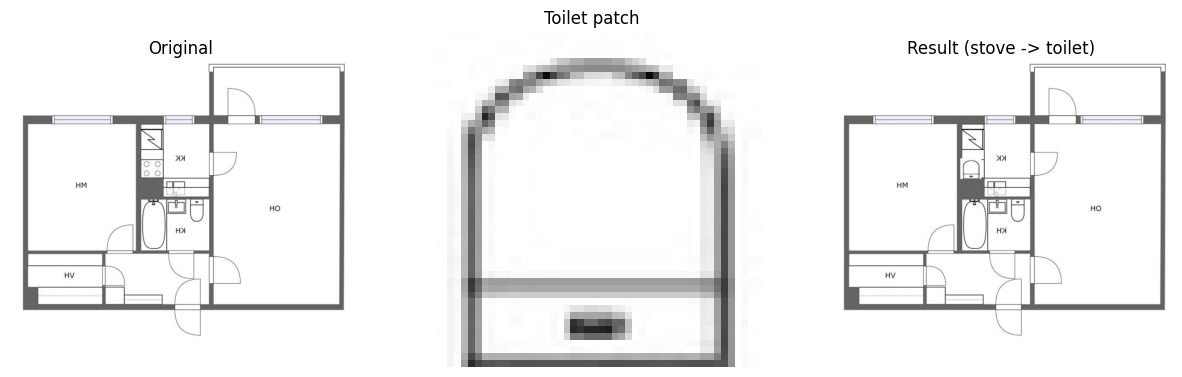

DONE ✅


In [10]:
import os, gc, random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
IMAGE_PATH      = r".\TestPlans\testPlan.PNG"

TARGET_LABEL_SUBSTR = "stove"
DETR_THRESH = 0.25

BOX_PAD = 2

# NEW: toilet patches directory
TOILET_DIR = r".\train_data\toilet"

# NEW: ink-mask settings (pasting only the black lines)
INK_THRESH = 240        # lower -> less ink, higher -> more ink
PATCH_DILATE = 1        # thicken lines a bit (0/1/2)

OUT_DIR = "outputs_stove_to_toilet_patch"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def draw_box(img_pil, box, color=(255,0,0), thickness=2):
    arr = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(arr, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(arr)

def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp")
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def pick_random_toilet_patch(folder):
    files = list_images(folder)
    if not files:
        raise RuntimeError(f"No images found in {folder}")
    return Image.open(random.choice(files)).convert("RGB")

def make_ink_mask(patch_rgb, ink_thresh=220, dilate=0):
    """
    Build mask where drawing/ink pixels are 255 (everything darker than ink_thresh).
    ink_thresh: 0..255, higher means include more gray pixels as "ink".
    dilate: 0/1/2 to slightly thicken strokes.
    """
    gray = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2GRAY)

    # ink = darker than threshold
    mask = (gray < int(ink_thresh)).astype(np.uint8) * 255

    # clean small noise (optional but usually good)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=1)

    # thicken strokes if needed
    if dilate and dilate > 0:
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate*2+1, dilate*2+1))
        mask = cv2.dilate(mask, k2, iterations=1)

    return mask



# =========================
# 1) DETR detect stove
# =========================
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

cands = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    if TARGET_LABEL_SUBSTR.lower() not in name.lower():
        continue
    b = bx.detach().cpu().numpy()
    x0,y0,x1,y1 = b
    area = max(1.0, (x1-x0)*(y1-y0))
    cands.append((float(sc), float(area), b, name))

# cleanup DETR
del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

if not cands:
    raise RuntimeError(f"No '{TARGET_LABEL_SUBSTR}' detected. Lower DETR_THRESH or adjust TARGET_LABEL_SUBSTR.")

cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
best_score, best_area, best_box, best_name = cands[0]

box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)
print(f"✅ Using {best_name}: score={best_score:.2f}, area={best_area:.1f}, box={box}")

# =========================
# 2) Fill the box with white (remove stove)
# =========================
out = np.array(image_pil).copy()
x0,y0,x1,y1 = box
out[y0:y1, x0:x1] = 255

# =========================
# 3) NEW: Paste a random TOILET patch into the same box (ink only)
# =========================
toilet_pil = pick_random_toilet_patch(TOILET_DIR)
toilet_pil = toilet_pil.resize((x1-x0, y1-y0), Image.Resampling.LANCZOS)

toilet_rgb = np.array(toilet_pil)
toilet_mask = make_ink_mask(toilet_rgb, ink_thresh=INK_THRESH, dilate=PATCH_DILATE)

# paste using mask: keep background white, paste only black lines
region = out[y0:y1, x0:x1].copy()
alpha = (toilet_mask.astype(np.float32) / 255.0)[..., None]
blended = region.astype(np.float32) * (1.0 - alpha) + toilet_rgb.astype(np.float32) * alpha
out[y0:y1, x0:x1] = np.clip(blended, 0, 255).astype(np.uint8)

out_pil = Image.fromarray(out)

# =========================
# Save
# =========================
image_pil.save(os.path.join(OUT_DIR, "orig.png"))
draw_box(image_pil, box).save(os.path.join(OUT_DIR, "box.png"))
toilet_pil.save(os.path.join(OUT_DIR, "toilet_patch_resized.png"))
Image.fromarray(toilet_mask).save(os.path.join(OUT_DIR, "toilet_mask.png"))
out_pil.save(os.path.join(OUT_DIR, "result.png"))

# show
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(1,3,2); plt.title("Toilet patch"); plt.imshow(toilet_pil); plt.axis("off")
plt.subplot(1,3,3); plt.title("Result (stove -> toilet)"); plt.imshow(out_pil); plt.axis("off")
plt.show()

print("DONE ✅")


פה הוא מושך מתוך השרטוט תמונה של האסלה ומחליף


DEVICE: cuda


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model,

✅ Using stove: score=0.57, box=[307, 231, 357, 280]


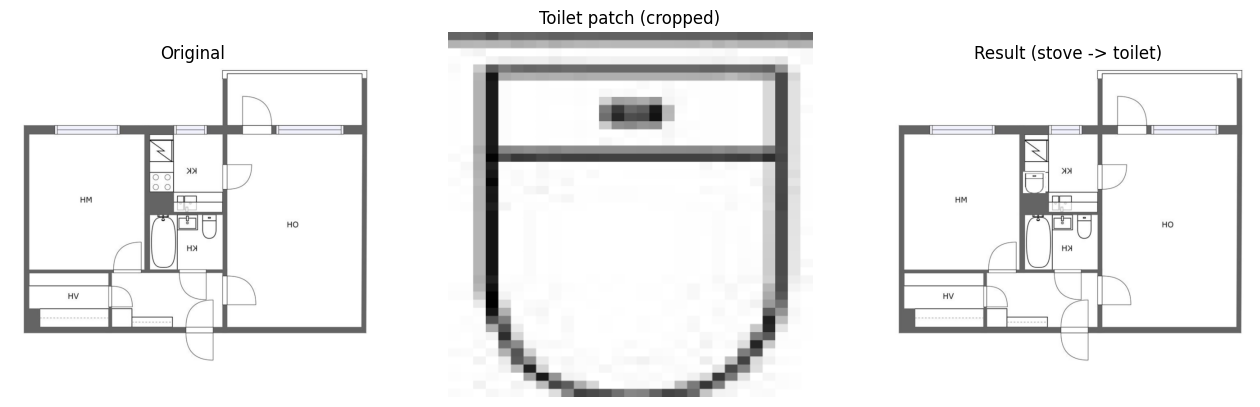

✅ Saved to outputs_stove_to_toilet_tightcrop
DONE ✅


In [14]:
import os, gc, random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
IMAGE_PATH      = r".\TestPlans\testPlan.PNG"

SOURCE_LABEL = "stove"
DETR_THRESH  = 0.25
BOX_PAD      = 2   # as requested

# Toilet patches directory
TOILET_DIR = r".\train_data\toilet"

# Ink mask parameters
INK_THRESH   = 220   # higher => more pixels counted as ink (try 220-245)
PATCH_DILATE = 0     # 0/1/2 thickens lines a bit
FEATHER_SIGMA = 0.6  # 0.0 disables soft edges

# If your toilet patches are tiny, increase this
MIN_PATCH_SIZE = 64

OUT_DIR = "outputs_stove_to_toilet_tightcrop"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def draw_box(img_pil, box, color=(255,0,0), thickness=2):
    arr = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(arr, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(arr)

def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp")
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def pick_random_patch(folder, min_size=64, tries=50):
    files = list_images(folder)
    if not files:
        raise RuntimeError(f"No images found in {folder}")
    for _ in range(tries):
        p = Image.open(random.choice(files)).convert("RGB")
        if min(p.size) >= min_size:
            return p
    return Image.open(random.choice(files)).convert("RGB")

def make_ink_mask(patch_rgb, ink_thresh=220, dilate=0):
    """
    Mask=255 where pixels are darker than ink_thresh (ink).
    """
    gray = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2GRAY)
    mask = (gray < int(ink_thresh)).astype(np.uint8) * 255

    # remove tiny noise
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=1)

    if dilate and dilate > 0:
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate*2+1, dilate*2+1))
        mask = cv2.dilate(mask, k2, iterations=1)

    return mask

def tight_crop_to_mask(patch_rgb, mask, margin=2):
    """
    Crops patch & mask to the tight bounding box of ink pixels.
    """
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        return patch_rgb, mask  # nothing to crop
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x0 = max(0, x0 - margin); y0 = max(0, y0 - margin)
    x1 = min(mask.shape[1]-1, x1 + margin); y1 = min(mask.shape[0]-1, y1 + margin)
    return patch_rgb[y0:y1+1, x0:x1+1], mask[y0:y1+1, x0:x1+1]

def resize_keep_aspect(patch_rgb, mask, target_w, target_h):
    """
    Resize patch to fit inside (target_w,target_h) while preserving aspect ratio.
    """
    ph, pw = patch_rgb.shape[:2]
    scale = min(target_w / max(1, pw), target_h / max(1, ph))
    nw = max(1, int(round(pw * scale)))
    nh = max(1, int(round(ph * scale)))

    patch_r = cv2.resize(
        patch_rgb, (nw, nh),
        interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC
    )
    mask_r = cv2.resize(mask, (nw, nh), interpolation=cv2.INTER_NEAREST)
    return patch_r, mask_r

def feather_mask(mask_uint8, sigma=0.6):
    if sigma <= 0:
        return mask_uint8
    return cv2.GaussianBlur(mask_uint8, (0,0), sigmaX=float(sigma))

# =========================
# 1) DETR detect stove
# =========================
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

cands = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    if name != SOURCE_LABEL:
        continue
    b = bx.detach().cpu().numpy()
    x0,y0,x1,y1 = b
    area = max(1.0, (x1-x0)*(y1-y0))
    cands.append((float(sc), float(area), b, name))

# cleanup DETR
del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

if not cands:
    raise RuntimeError(f"No '{SOURCE_LABEL}' detected. Try DETR_THRESH=0.15.")

cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
best_score, best_area, best_box, best_name = cands[0]

box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)
x0,y0,x1,y1 = box
bw, bh = (x1-x0), (y1-y0)

print(f"✅ Using {best_name}: score={best_score:.2f}, box={box}")

# =========================
# 2) Fill box with white (remove stove)
# =========================
out = np.array(image_pil).copy()
out[y0:y1, x0:x1] = 255

# =========================
# 3) Load toilet patch -> ink mask -> tight crop -> resize -> paste centered
# =========================
toilet_pil = pick_random_patch(TOILET_DIR, min_size=MIN_PATCH_SIZE)
toilet_rgb = np.array(toilet_pil)

mask = make_ink_mask(toilet_rgb, ink_thresh=INK_THRESH, dilate=PATCH_DILATE)
toilet_rgb_c, mask_c = tight_crop_to_mask(toilet_rgb, mask, margin=2)

# resize (keep aspect)
patch_r, mask_r = resize_keep_aspect(toilet_rgb_c, mask_c, bw, bh)
mask_r = feather_mask(mask_r, sigma=FEATHER_SIGMA)

ph, pw = patch_r.shape[:2]
px0 = x0 + (bw - pw)//2
py0 = y0 + (bh - ph)//2

# clamp inside image
px0 = max(0, min(W - pw, px0))
py0 = max(0, min(H - ph, py0))

region = out[py0:py0+ph, px0:px0+pw].astype(np.float32)
alpha = (mask_r.astype(np.float32) / 255.0)[..., None]
blended = region * (1.0 - alpha) + patch_r.astype(np.float32) * alpha
out[py0:py0+ph, px0:px0+pw] = np.clip(blended, 0, 255).astype(np.uint8)

out_pil = Image.fromarray(out)

# =========================
# Save
# =========================
image_pil.save(os.path.join(OUT_DIR, "orig.png"))
draw_box(image_pil, box).save(os.path.join(OUT_DIR, "box.png"))

Image.fromarray(mask).save(os.path.join(OUT_DIR, "toilet_mask_full.png"))
Image.fromarray(toilet_rgb).save(os.path.join(OUT_DIR, "toilet_patch_full.png"))

Image.fromarray(mask_c).save(os.path.join(OUT_DIR, "toilet_mask_cropped.png"))
Image.fromarray(toilet_rgb_c).save(os.path.join(OUT_DIR, "toilet_patch_cropped.png"))

Image.fromarray(mask_r.astype(np.uint8)).save(os.path.join(OUT_DIR, "toilet_mask_resized.png"))
Image.fromarray(patch_r).save(os.path.join(OUT_DIR, "toilet_patch_resized.png"))

out_pil.save(os.path.join(OUT_DIR, "result.png"))

# show
plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(1,3,2); plt.title("Toilet patch (cropped)"); plt.imshow(Image.fromarray(toilet_rgb_c)); plt.axis("off")
plt.subplot(1,3,3); plt.title("Result (stove -> toilet)"); plt.imshow(out_pil); plt.axis("off")
plt.show()

print(f"✅ Saved to {OUT_DIR}")
print("DONE ✅")


מה זה עושה?

אחרי ש־DETR מצא את ה־stove ואנחנו ממלאים בלבן, אנחנו:

מסתכלים מסביב ל־box ומחפשים איפה יש “קיר” (פיקסלים כהים / קווים עבים)

מחליטים איזה צד של ה־box הוא הקיר: top / bottom / left / right

מסובבים את ה־toilet patch בהתאם:

קיר למעלה → אסלה “נדבקת” למעלה (0°)

קיר למטה → 180°

קיר משמאל → 90°

קיר מימין → 270°

גם מזיזים את ההדבקה בתוך ה־box כך שהאסלה תהיה “צמודה” לצד הקיר.

In [1]:
import os, gc
import numpy as np
import cv2
import torch
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
IMAGE_PATH      = r".\TestPlans\testPlan.PNG"
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"

TARGET_LABEL = "closet"
DETR_THRESH  = 0.20

OUT_DIR = r".\outputs_add_closet_auto_adaptive_cleanwalls"
os.makedirs(OUT_DIR, exist_ok=True)

# Maps / Interior (color-agnostic)
WALL_KERNEL = 11
INTERIOR_CLOSE_KERNEL = 25   # 25~41 (bigger closes more gaps)

# Scan
MARGIN = 10
STRIDE = 4                   # 4 is safer

# Interior constraint (must be inside apartment)
MIN_INTERIOR_FRAC = 0.95

# Busy-area constraint (coarse)
MAX_BLACK_FRAC_IN_TARGET = 0.18  # allow more; overlap check is the real gatekeeper

# Overlap avoidance
EXISTING_DILATE = 3               # thicken existing ink before overlap test
MAX_OVERLAP_PIXELS_BASE = 6       # adaptive will relax if needed
MAX_OVERLAP_FRAC_BASE   = 0.01    # adaptive will relax if needed

# Mask blending
FEATHER_SIGMA = 0.6

# Template filtering
MIN_TEMPLATE_SIZE = 18
MAX_TEMPLATE_REL = 0.45
BOX_PAD = 2

# Auto-scale fallback if no room
SCALES = [1.0, 0.9, 0.8, 0.7, 0.6]

# Adaptive wall bands (near-wall placement region)
BANDS = [10, 14, 18, 24, 30]

# Adaptive overlap relax
OV_PIX_LIST  = [MAX_OVERLAP_PIXELS_BASE, 10, 16, 24]
OV_FRAC_LIST = [MAX_OVERLAP_FRAC_BASE,   0.02, 0.03, 0.05]

# Thick-wall cleanup (to avoid text being treated as wall)
# If too aggressive (no walls left), lower min_area / min_long_side.
THICK_MIN_AREA      = 2500
THICK_MIN_LONG_SIDE = 160
THICK_MIN_SHORT_SIDE = 6

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def filter_thick_map_components(thick_map,
                                min_area=1500,
                                min_long_side=120,
                                min_short_side=6):
    """
    Remove text/small blobs from thick_map by keeping only wall-like components.
    Keeps components that are:
      - large enough (area)
      - long enough (long_side)
      - not too thin (short_side)
    Returns cleaned thick_map (uint8 0/255).
    """
    bw = (thick_map > 0).astype(np.uint8)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(bw, connectivity=8)
    out = np.zeros_like(bw)

    for i in range(1, num):  # 0 is background
        x, y, w, h, area = stats[i]
        long_side = max(w, h)
        short_side = min(w, h)

        if area < min_area:
            continue
        if long_side < min_long_side:
            continue
        if short_side < min_short_side:
            continue

        out[labels == i] = 1

    return (out * 255).astype(np.uint8)

def build_line_maps(img_bgr, wall_kernel):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, bin_inv = cv2.threshold(gray, 235, 255, cv2.THRESH_BINARY_INV)  # 255=ink/lines

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (wall_kernel, wall_kernel))
    thick = cv2.morphologyEx(bin_inv, cv2.MORPH_CLOSE, k, iterations=1)
    thick = cv2.erode(thick, np.ones((3,3), np.uint8), iterations=1)

    # ✅ Clean thick map so text isn't treated like wall
    thick_clean = filter_thick_map_components(
        thick,
        min_area=THICK_MIN_AREA,
        min_long_side=THICK_MIN_LONG_SIDE,
        min_short_side=THICK_MIN_SHORT_SIDE
    )
    return bin_inv, thick_clean

def build_interior_mask_anycolor(img_bgr, close_kernel=25):
    H, W = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Ink = not-white (tune 240-248 if needed)
    ink = (gray < 245).astype(np.uint8) * 255

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_kernel, close_kernel))
    ink_closed = cv2.morphologyEx(ink, cv2.MORPH_CLOSE, k, iterations=1)

    free = cv2.bitwise_not(ink_closed)  # 255 free space
    ff = free.copy()
    mask = np.zeros((H + 2, W + 2), dtype=np.uint8)

    for seed in [(0,0), (W-1,0), (0,H-1), (W-1,H-1)]:
        if ff[seed[1], seed[0]] == 255:
            cv2.floodFill(ff, mask, seedPoint=seed, newVal=0)

    inside_free = ff  # 255 = inside free-space
    outside_free = cv2.bitwise_and(free, cv2.bitwise_not(inside_free))
    interior = cv2.bitwise_and(inside_free, cv2.bitwise_not(ink_closed))
    return interior, ink_closed, outside_free

def build_placement_mask(interior_mask, thick_map, wall_band):
    """
    Placement band near thick walls (within wall_band pixels), intersected with interior.
    """
    thick_bin = (thick_map > 0).astype(np.uint8)
    dist = cv2.distanceTransform(1 - thick_bin, cv2.DIST_L2, 3)
    near_wall = (dist <= wall_band).astype(np.uint8) * 255
    placement = cv2.bitwise_and(interior_mask, near_wall)
    return placement

def mask_from_crop_nonwhite(crop_bgr, feather_sigma):
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)
    hard = cv2.inRange(gray, 0, 245)  # 255 = non-white ink
    hard = cv2.morphologyEx(hard, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=1)
    soft = hard.copy()
    if feather_sigma and feather_sigma > 0:
        soft = cv2.GaussianBlur(soft, (0,0), sigmaX=float(feather_sigma))
    return hard, soft

def alpha_paste(base_bgr, crop_bgr, mask_uint8, x, y):
    h, w = crop_bgr.shape[:2]
    roi = base_bgr[y:y+h, x:x+w]
    m = (mask_uint8.astype(np.float32) / 255.0)[..., None]
    out = roi.astype(np.float32) * (1.0 - m) + crop_bgr.astype(np.float32) * m
    base_bgr[y:y+h, x:x+w] = np.clip(out, 0, 255).astype(np.uint8)
    return base_bgr

def resize_template(template, mask_hard, mask_soft, scale):
    h, w = template.shape[:2]
    nw = max(8, int(w * scale))
    nh = max(8, int(h * scale))
    t2  = cv2.resize(template,  (nw, nh), interpolation=cv2.INTER_AREA)
    mh2 = cv2.resize(mask_hard, (nw, nh), interpolation=cv2.INTER_NEAREST)
    ms2 = cv2.resize(mask_soft, (nw, nh), interpolation=cv2.INTER_NEAREST)
    return t2, mh2, ms2

def choose_template_highest_score(templates):
    templates.sort(key=lambda t: t["score"], reverse=True)
    return templates[0]

def find_best_spot_adaptive(interior_mask, placement_mask, bin_inv_lines,
                            template_mask_hard, roi_w, roi_h,
                            margin, stride,
                            min_interior_frac,
                            max_black_frac,
                            existing_dilate,
                            max_overlap_pixels,
                            max_overlap_frac):
    H, W = interior_mask.shape[:2]

    # dilate existing ink (forbidden zone around objects/lines)
    ink = (bin_inv_lines > 0).astype(np.uint8) * 255
    if existing_dilate and existing_dilate > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*existing_dilate+1, 2*existing_dilate+1))
        ink_dil = cv2.dilate(ink, k, iterations=1)
    else:
        ink_dil = ink

    mh = (template_mask_hard > 0).astype(np.uint8)
    mh_sum = int(mh.sum())
    if mh_sum == 0:
        return None

    best = None
    best_score = -1e18

    for y in range(margin, H - roi_h - margin, stride):
        for x in range(margin, W - roi_w - margin, stride):

            # must be inside apartment (most of ROI)
            roi_int = interior_mask[y:y+roi_h, x:x+roi_w]
            interior_frac = float((roi_int > 0).mean())
            if interior_frac < min_interior_frac:
                continue

            # must be near wall: ROI CENTER must be in placement_mask
            cx = x + roi_w // 2
            cy = y + roi_h // 2
            if placement_mask[cy, cx] == 0:
                continue

            # coarse busy filter
            roi_ink = bin_inv_lines[y:y+roi_h, x:x+roi_w]
            black_frac = float((roi_ink > 0).mean())
            if black_frac > max_black_frac:
                continue

            # overlap check under closet ink only
            roi_exist = (ink_dil[y:y+roi_h, x:x+roi_w] > 0).astype(np.uint8)
            overlap_pixels = int((roi_exist * mh).sum())
            if overlap_pixels > max_overlap_pixels:
                continue

            overlap_frac = overlap_pixels / float(mh_sum)
            if overlap_frac > max_overlap_frac:
                continue

            # score: prefer cleaner + less overlap + more interior coverage
            score = (1.0 - black_frac) * 1.5 + (1.0 - overlap_frac) * 4.0 + interior_frac * 0.5

            if score > best_score:
                best_score = score
                best = (x, y, black_frac, interior_frac, overlap_frac, overlap_pixels)

    return best

# =========================
# 1) Load image
# =========================
img_pil = Image.open(IMAGE_PATH).convert("RGB")
img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
H, W = img_bgr.shape[:2]

# =========================
# 2) DETR detect closets (template from same image)
# =========================
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

inputs = processor(images=img_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([img_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

templates = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    if id2label[int(lab)] != TARGET_LABEL:
        continue

    b = expand_box_xyxy(bx.detach().cpu().numpy(), W, H, BOX_PAD)
    x0,y0,x1,y1 = map(int, b)

    crop = img_bgr[y0:y1, x0:x1].copy()
    if crop.size == 0:
        continue

    th, tw = crop.shape[:2]
    if th < MIN_TEMPLATE_SIZE or tw < MIN_TEMPLATE_SIZE:
        continue
    if tw > W * MAX_TEMPLATE_REL or th > H * MAX_TEMPLATE_REL:
        continue

    mh, ms = mask_from_crop_nonwhite(crop, FEATHER_SIGMA)
    templates.append({
        "crop": crop,
        "mask_hard": mh,
        "mask_soft": ms,
        "box": (x0,y0,x1,y1),
        "score": float(sc)
    })

if not templates:
    raise RuntimeError("No closets detected. Lower DETR_THRESH or check label mapping.")

canon = choose_template_highest_score(templates)
template = canon["crop"]
template_mask_hard = canon["mask_hard"]
template_mask_soft = canon["mask_soft"]
sx0,sy0,sx1,sy1 = canon["box"]
print(f"✅ Template: box={canon['box']} score={canon['score']:.2f} size={template.shape[1]}x{template.shape[0]}")

# =========================
# 3) Build masks
# =========================
bin_inv_lines, thick_map = build_line_maps(img_bgr, WALL_KERNEL)
interior_mask, ink_closed, outside_mask = build_interior_mask_anycolor(img_bgr, close_kernel=INTERIOR_CLOSE_KERNEL)

# Debug saves
cv2.imwrite(os.path.join(OUT_DIR, "orig.png"), cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
cv2.imwrite(os.path.join(OUT_DIR, "thick_walls_clean.png"), thick_map)
cv2.imwrite(os.path.join(OUT_DIR, "interior_mask.png"), interior_mask)
cv2.imwrite(os.path.join(OUT_DIR, "ink_closed.png"), ink_closed)
cv2.imwrite(os.path.join(OUT_DIR, "outside_mask.png"), outside_mask)

# =========================
# 4) Adaptive search over wall band + overlap constraints + scale
# =========================
best = None
chosen_scale = None
chosen_band = None
chosen_ov_pix = None
chosen_ov_frac = None

for band in BANDS:
    placement_mask = build_placement_mask(interior_mask, thick_map, wall_band=band)
    cv2.imwrite(os.path.join(OUT_DIR, f"placement_mask_band_{band}.png"), placement_mask)

    if int((placement_mask > 0).sum()) < 1000:
        continue

    for ov_pix in OV_PIX_LIST:
        for ov_frac in OV_FRAC_LIST:
            for sc in SCALES:
                t_try, mh_try, ms_try = resize_template(template, template_mask_hard, template_mask_soft, sc)
                roi_h, roi_w = t_try.shape[:2]

                best_try = find_best_spot_adaptive(
                    interior_mask=interior_mask,
                    placement_mask=placement_mask,
                    bin_inv_lines=bin_inv_lines,
                    template_mask_hard=mh_try,
                    roi_w=roi_w, roi_h=roi_h,
                    margin=MARGIN, stride=STRIDE,
                    min_interior_frac=MIN_INTERIOR_FRAC,
                    max_black_frac=MAX_BLACK_FRAC_IN_TARGET,
                    existing_dilate=EXISTING_DILATE,
                    max_overlap_pixels=ov_pix,
                    max_overlap_frac=ov_frac
                )

                if best_try is not None:
                    best = best_try
                    template, template_mask_hard, template_mask_soft = t_try, mh_try, ms_try
                    chosen_scale = sc
                    chosen_band = band
                    chosen_ov_pix = ov_pix
                    chosen_ov_frac = ov_frac
                    break
            if best is not None:
                break
        if best is not None:
            break
    if best is not None:
        break

if best is None:
    raise RuntimeError(
        "No placement found even with adaptive search.\n"
        "If thick_walls_clean.png lost real walls -> lower THICK_MIN_AREA (800) and THICK_MIN_LONG_SIDE (80).\n"
        "If interior_mask.png is broken -> raise INTERIOR_CLOSE_KERNEL (31/41) or change ink threshold (245->248)."
    )

px, py, black_frac, interior_frac, ov_f, ov_p = best
roi_h, roi_w = template.shape[:2]
print(f"✅ Placement: ({px},{py}) band={chosen_band} scale={chosen_scale} "
      f"black={black_frac:.3f} interior={interior_frac:.3f} overlap={ov_f:.4f} px={ov_p} "
      f"(ov_pix_cap={chosen_ov_pix}, ov_frac_cap={chosen_ov_frac})")

# =========================
# 5) Paste + Save
# =========================
out = img_bgr.copy()
out = alpha_paste(out, template, template_mask_soft, px, py)

viz = out.copy()
cv2.rectangle(viz, (sx0,sy0), (sx1,sy1), (255,0,0), 2)                 # source closet (blue)
cv2.rectangle(viz, (px,py), (px+roi_w, py+roi_h), (0,0,255), 2)        # placed closet (red)

cv2.imwrite(os.path.join(OUT_DIR, "canonical_template.png"), template)
cv2.imwrite(os.path.join(OUT_DIR, "canonical_mask_hard.png"), template_mask_hard)
cv2.imwrite(os.path.join(OUT_DIR, "canonical_mask_soft.png"), template_mask_soft)
cv2.imwrite(os.path.join(OUT_DIR, "result.png"), out)
cv2.imwrite(os.path.join(OUT_DIR, "result_box.png"), viz)

print("✅ DONE. Saved to:", OUT_DIR)


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model,

✅ Template: box=(81, 534, 212, 578) score=0.91 size=131x44
✅ Placement: (698,98) band=18 scale=0.6 black=0.000 interior=1.000 overlap=0.0000 px=0 (ov_pix_cap=6, ov_frac_cap=0.01)
✅ DONE. Saved to: .\outputs_add_closet_auto_adaptive_cleanwalls


DEVICE: cuda
✅ Using toilet: score=0.52, box=[201, 301, 237, 335]


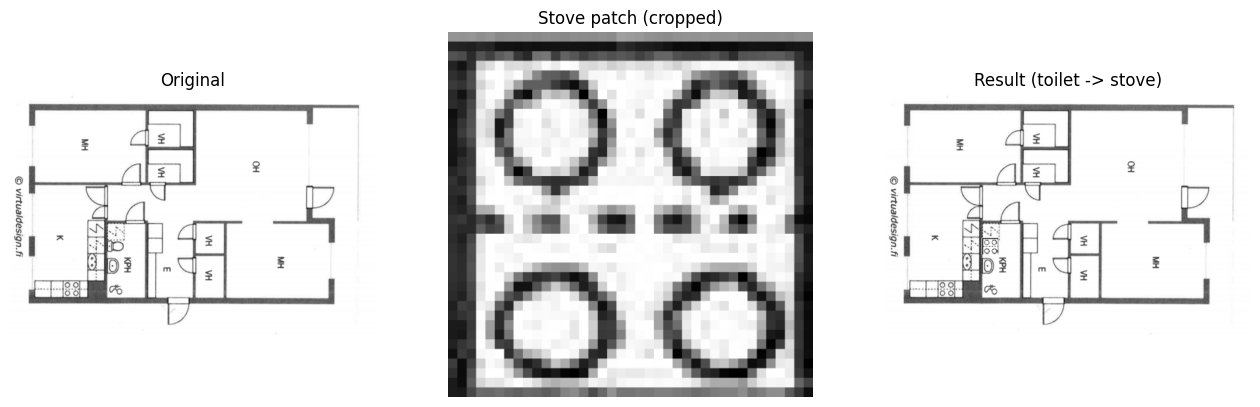

✅ Saved to outputs_toilet_to_stove_tightcrop
DONE ✅


In [ ]:
import os, gc, random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
IMAGE_PATH      = r".\TestPlans\testPlan4.PNG"

SOURCE_LABEL = "toilet"
DETR_THRESH  = 0.25
BOX_PAD      = 2   # as requested

# Stove patches directory
STOVE_DIR = r".\train_data\stove"

# Ink mask parameters
INK_THRESH    = 220   # higher => more pixels counted as ink (try 220-245)
PATCH_DILATE  = 0     # 0/1/2 thickens lines a bit
FEATHER_SIGMA = 0.6   # 0.0 disables soft edges

# If your stove patches are tiny, increase this
MIN_PATCH_SIZE = 64

OUT_DIR = "outputs_toilet_to_stove_tightcrop"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def draw_box(img_pil, box, color=(255,0,0), thickness=2):
    arr = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(arr, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(arr)

def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp")
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def pick_random_patch(folder, min_size=64, tries=50):
    files = list_images(folder)
    if not files:
        raise RuntimeError(f"No images found in {folder}")
    for _ in range(tries):
        p = Image.open(random.choice(files)).convert("RGB")
        if min(p.size) >= min_size:
            return p
    return Image.open(random.choice(files)).convert("RGB")

def make_ink_mask(patch_rgb, ink_thresh=220, dilate=0):
    """
    Mask=255 where pixels are darker than ink_thresh (ink).
    """
    gray = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2GRAY)
    mask = (gray < int(ink_thresh)).astype(np.uint8) * 255

    # remove tiny noise
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=1)

    if dilate and dilate > 0:
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate*2+1, dilate*2+1))
        mask = cv2.dilate(mask, k2, iterations=1)

    return mask

def tight_crop_to_mask(patch_rgb, mask, margin=2):
    """
    Crops patch & mask to the tight bounding box of ink pixels.
    """
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        return patch_rgb, mask  # nothing to crop
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x0 = max(0, x0 - margin); y0 = max(0, y0 - margin)
    x1 = min(mask.shape[1]-1, x1 + margin); y1 = min(mask.shape[0]-1, y1 + margin)
    return patch_rgb[y0:y1+1, x0:x1+1], mask[y0:y1+1, x0:x1+1]

def resize_keep_aspect(patch_rgb, mask, target_w, target_h):
    """
    Resize patch to fit inside (target_w,target_h) while preserving aspect ratio.
    """
    ph, pw = patch_rgb.shape[:2]
    scale = min(target_w / max(1, pw), target_h / max(1, ph))
    nw = max(1, int(round(pw * scale)))
    nh = max(1, int(round(ph * scale)))

    patch_r = cv2.resize(
        patch_rgb, (nw, nh),
        interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC
    )
    mask_r = cv2.resize(mask, (nw, nh), interpolation=cv2.INTER_NEAREST)
    return patch_r, mask_r

def feather_mask(mask_uint8, sigma=0.6):
    if sigma <= 0:
        return mask_uint8
    return cv2.GaussianBlur(mask_uint8, (0,0), sigmaX=float(sigma))

# =========================
# 1) DETR detect toilet
# =========================
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

cands = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    if name != SOURCE_LABEL:
        continue
    b = bx.detach().cpu().numpy()
    x0,y0,x1,y1 = b
    area = max(1.0, (x1-x0)*(y1-y0))
    cands.append((float(sc), float(area), b, name))

# cleanup DETR
del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

if not cands:
    raise RuntimeError(f"No '{SOURCE_LABEL}' detected. Try DETR_THRESH=0.15.")

cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
best_score, best_area, best_box, best_name = cands[0]

box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)
x0,y0,x1,y1 = box
bw, bh = (x1-x0), (y1-y0)

print(f"✅ Using {best_name}: score={best_score:.2f}, box={box}")

# =========================
# 2) Fill box with white (remove toilet)
# =========================
out = np.array(image_pil).copy()
out[y0:y1, x0:x1] = 255

# =========================
# 3) Load stove patch -> ink mask -> tight crop -> resize -> paste centered
# =========================
stove_pil = pick_random_patch(STOVE_DIR, min_size=MIN_PATCH_SIZE)
stove_rgb = np.array(stove_pil)

mask = make_ink_mask(stove_rgb, ink_thresh=INK_THRESH, dilate=PATCH_DILATE)
stove_rgb_c, mask_c = tight_crop_to_mask(stove_rgb, mask, margin=2)

# resize (keep aspect)
patch_r, mask_r = resize_keep_aspect(stove_rgb_c, mask_c, bw, bh)
mask_r = feather_mask(mask_r, sigma=FEATHER_SIGMA)

ph, pw = patch_r.shape[:2]
px0 = x0 + (bw - pw)//2
py0 = y0 + (bh - ph)//2

# clamp inside image
px0 = max(0, min(W - pw, px0))
py0 = max(0, min(H - ph, py0))

region = out[py0:py0+ph, px0:px0+pw].astype(np.float32)
alpha = (mask_r.astype(np.float32) / 255.0)[..., None]
blended = region * (1.0 - alpha) + patch_r.astype(np.float32) * alpha
out[py0:py0+ph, px0:px0+pw] = np.clip(blended, 0, 255).astype(np.uint8)

out_pil = Image.fromarray(out)

# =========================
# Save
# =========================
image_pil.save(os.path.join(OUT_DIR, "orig.png"))
draw_box(image_pil, box).save(os.path.join(OUT_DIR, "box.png"))

Image.fromarray(mask).save(os.path.join(OUT_DIR, "stove_mask_full.png"))
Image.fromarray(stove_rgb).save(os.path.join(OUT_DIR, "stove_patch_full.png"))

Image.fromarray(mask_c).save(os.path.join(OUT_DIR, "stove_mask_cropped.png"))
Image.fromarray(stove_rgb_c).save(os.path.join(OUT_DIR, "stove_patch_cropped.png"))

Image.fromarray(mask_r.astype(np.uint8)).save(os.path.join(OUT_DIR, "stove_mask_resized.png"))
Image.fromarray(patch_r).save(os.path.join(OUT_DIR, "stove_patch_resized.png"))

out_pil.save(os.path.join(OUT_DIR, "result.png"))

# show
plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(1,3,2); plt.title("Stove patch (cropped)"); plt.imshow(Image.fromarray(stove_rgb_c)); plt.axis("off")
plt.subplot(1,3,3); plt.title("Result (toilet -> stove)"); plt.imshow(out_pil); plt.axis("off")
plt.show()

print(f"✅ Saved to {OUT_DIR}")
print("DONE ✅")


הקוד הבא הוא ממש כמו הקודם שהחליף אסלה עם כיריים רק שהפעם מחליף כיור עם כיריים

# Pipeline: Sink → Stove (Patch-Based Replacement)

## Input
- Floorplan image (RGB)
- Fine-tuned DETR model for object detection
- External stove “patches” folder (generated symbol images)

## Steps
1. **Detect target object (Sink)**
   - Run DETR on the input floorplan
   - Filter predictions by `label == "sink"` and score threshold
   - Select the best bounding box (highest score, then largest area)

2. **Remove the object**
   - Expand the box slightly (`BOX_PAD`)
   - Fill the bounding box area with white (background)

3. **Load replacement patch (Stove)**
   - Randomly select a stove patch image from `train_data/stove`
   - Create an ink mask using grayscale threshold (`INK_THRESH`)
   - Tight-crop patch to ink pixels and resize to fit the target box (aspect-preserving)

4. **Paste replacement**
   - Center the resized patch inside the original box
   - Alpha-blend using the ink mask (optional feathering)

## Output
- Modified floorplan image where **sink is replaced by stove**
- Debug images: bounding box, patch, masks, resized patch, final result

## Note
- The replacement symbol is taken from the **external patch images** (your generated dataset).
- The code does **not** cut a stove from the input image itself.


DEVICE: cuda
✅ Using sink: score=0.76, box=[160, 332, 194, 370]


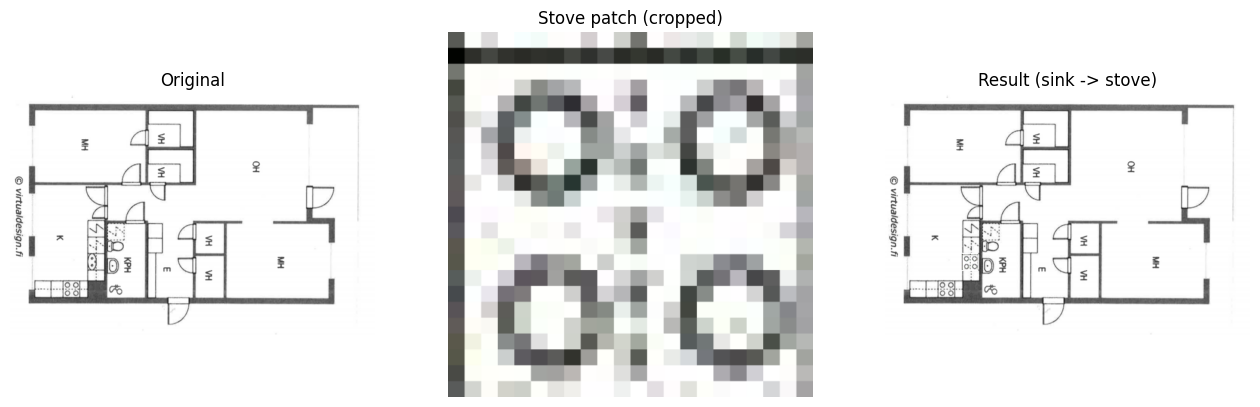

✅ Saved to outputs_sink_to_stove_tightcrop
DONE ✅


In [30]:
import os, gc, random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
IMAGE_PATH      = r".\TestPlans\testPlan4.PNG"

# CHANGE HERE: replace sink with stove
SOURCE_LABEL = "sink"     # <- was "toilet"
DETR_THRESH  = 0.25
BOX_PAD      = 2

# Stove patches directory (YOUR generated images)
STOVE_DIR = r".\train_data\stove"

# Ink mask parameters
INK_THRESH     = 220
PATCH_DILATE   = 0
FEATHER_SIGMA  = 0.6

MIN_PATCH_SIZE = 64
OUT_DIR = "outputs_sink_to_stove_tightcrop"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def draw_box(img_pil, box, color=(255,0,0), thickness=2):
    arr = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(arr, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(arr)

def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp")
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def pick_random_patch(folder, min_size=64, tries=50):
    files = list_images(folder)
    if not files:
        raise RuntimeError(f"No images found in {folder}")
    for _ in range(tries):
        p = Image.open(random.choice(files)).convert("RGB")
        if min(p.size) >= min_size:
            return p
    return Image.open(random.choice(files)).convert("RGB")

def make_ink_mask(patch_rgb, ink_thresh=220, dilate=0):
    """
    Mask=255 where pixels are darker than ink_thresh (ink).
    """
    gray = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2GRAY)
    mask = (gray < int(ink_thresh)).astype(np.uint8) * 255

    # remove tiny noise
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=1)

    if dilate and dilate > 0:
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate*2+1, dilate*2+1))
        mask = cv2.dilate(mask, k2, iterations=1)

    return mask

def tight_crop_to_mask(patch_rgb, mask, margin=2):
    """
    Crops patch & mask to the tight bounding box of ink pixels.
    """
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        return patch_rgb, mask
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x0 = max(0, x0 - margin); y0 = max(0, y0 - margin)
    x1 = min(mask.shape[1]-1, x1 + margin); y1 = min(mask.shape[0]-1, y1 + margin)
    return patch_rgb[y0:y1+1, x0:x1+1], mask[y0:y1+1, x0:x1+1]

def resize_keep_aspect(patch_rgb, mask, target_w, target_h):
    """
    Resize patch to fit inside (target_w,target_h) while preserving aspect ratio.
    """
    ph, pw = patch_rgb.shape[:2]
    scale = min(target_w / max(1, pw), target_h / max(1, ph))
    nw = max(1, int(round(pw * scale)))
    nh = max(1, int(round(ph * scale)))

    patch_r = cv2.resize(
        patch_rgb, (nw, nh),
        interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC
    )
    mask_r = cv2.resize(mask, (nw, nh), interpolation=cv2.INTER_NEAREST)
    return patch_r, mask_r

def feather_mask(mask_uint8, sigma=0.6):
    if sigma <= 0:
        return mask_uint8
    return cv2.GaussianBlur(mask_uint8, (0,0), sigmaX=float(sigma))

# =========================
# 1) DETR detect sink
# =========================
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

cands = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    if name != SOURCE_LABEL:
        continue
    b = bx.detach().cpu().numpy()
    x0,y0,x1,y1 = b
    area = max(1.0, (x1-x0)*(y1-y0))
    cands.append((float(sc), float(area), b, name))

# cleanup DETR
del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

if not cands:
    raise RuntimeError(f"No '{SOURCE_LABEL}' detected. Try DETR_THRESH=0.15.")

cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
best_score, best_area, best_box, best_name = cands[0]

box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)
x0,y0,x1,y1 = box
bw, bh = (x1-x0), (y1-y0)

print(f"✅ Using {best_name}: score={best_score:.2f}, box={box}")

# =========================
# 2) Fill box with white (remove sink)
# =========================
out = np.array(image_pil).copy()
out[y0:y1, x0:x1] = 255

# =========================
# 3) Load stove patch -> ink mask -> tight crop -> resize -> paste centered
# =========================
stove_pil = pick_random_patch(STOVE_DIR, min_size=MIN_PATCH_SIZE)
stove_rgb = np.array(stove_pil)

mask = make_ink_mask(stove_rgb, ink_thresh=INK_THRESH, dilate=PATCH_DILATE)
stove_rgb_c, mask_c = tight_crop_to_mask(stove_rgb, mask, margin=2)

# resize (keep aspect)
patch_r, mask_r = resize_keep_aspect(stove_rgb_c, mask_c, bw, bh)
mask_r = feather_mask(mask_r, sigma=FEATHER_SIGMA)

ph, pw = patch_r.shape[:2]
px0 = x0 + (bw - pw)//2
py0 = y0 + (bh - ph)//2

# clamp inside image
px0 = max(0, min(W - pw, px0))
py0 = max(0, min(H - ph, py0))

region = out[py0:py0+ph, px0:px0+pw].astype(np.float32)
alpha = (mask_r.astype(np.float32) / 255.0)[..., None]
blended = region * (1.0 - alpha) + patch_r.astype(np.float32) * alpha
out[py0:py0+ph, px0:px0+pw] = np.clip(blended, 0, 255).astype(np.uint8)

out_pil = Image.fromarray(out)

# =========================
# Save
# =========================
image_pil.save(os.path.join(OUT_DIR, "orig.png"))
draw_box(image_pil, box).save(os.path.join(OUT_DIR, "box.png"))

Image.fromarray(mask).save(os.path.join(OUT_DIR, "stove_mask_full.png"))
Image.fromarray(stove_rgb).save(os.path.join(OUT_DIR, "stove_patch_full.png"))

Image.fromarray(mask_c).save(os.path.join(OUT_DIR, "stove_mask_cropped.png"))
Image.fromarray(stove_rgb_c).save(os.path.join(OUT_DIR, "stove_patch_cropped.png"))

Image.fromarray(mask_r.astype(np.uint8)).save(os.path.join(OUT_DIR, "stove_mask_resized.png"))
Image.fromarray(patch_r).save(os.path.join(OUT_DIR, "stove_patch_resized.png"))

out_pil.save(os.path.join(OUT_DIR, "result.png"))

# show
plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(1,3,2); plt.title("Stove patch (cropped)"); plt.imshow(Image.fromarray(stove_rgb_c)); plt.axis("off")
plt.subplot(1,3,3); plt.title("Result (sink -> stove)"); plt.imshow(out_pil); plt.axis("off")
plt.show()

print(f"✅ Saved to {OUT_DIR}")
print("DONE ✅")


בזה לא השתמשנו: זה כשהוא חותך פאץ מתוך הסרטוט ולא מתוך המאגר

In [ ]:
import os, gc
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
IMAGE_PATH      = r"synthetic_dataset\images_before\image_022.jpg"

DETR_THRESH  = 0.25
BOX_PAD      = 2

# Update if your label name differs
STOVE_LABEL = "stove"

# Mask parameters (from crop itself)
CROP_INK_THRESH = 245     # treat anything darker than this as ink
CROP_CLOSE_ITERS = 1
FEATHER_SIGMA  = 0.6

# Template filtering
MIN_TEMPLATE_SIZE = 18
MAX_TEMPLATE_REL  = 0.45   # max relative size of the whole image

OUT_DIR = "outputs_sink_and_toilet_to_stove_from_same_plan_proportional"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def draw_box(img_pil, box, color=(255,0,0), thickness=2):
    arr = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(arr, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(arr)

def crop_from_box(img_rgb, box_xyxy):
    x0,y0,x1,y1 = map(int, box_xyxy)
    return img_rgb[y0:y1, x0:x1].copy()

def mask_from_crop_nonwhite(crop_rgb, ink_thresh=245, close_iters=1, feather_sigma=0.6):
    gray = cv2.cvtColor(crop_rgb, cv2.COLOR_RGB2GRAY)
    hard = (gray < int(ink_thresh)).astype(np.uint8) * 255
    if close_iters and close_iters > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        hard = cv2.morphologyEx(hard, cv2.MORPH_CLOSE, k, iterations=int(close_iters))
    soft = hard.copy()
    if feather_sigma and feather_sigma > 0:
        soft = cv2.GaussianBlur(soft, (0,0), sigmaX=float(feather_sigma))
    return hard, soft

def tight_crop_to_mask(patch_rgb, mask, margin=2):
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        return patch_rgb, mask
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x0 = max(0, x0 - margin); y0 = max(0, y0 - margin)
    x1 = min(mask.shape[1]-1, x1 + margin); y1 = min(mask.shape[0]-1, y1 + margin)
    return patch_rgb[y0:y1+1, x0:x1+1], mask[y0:y1+1, x0:x1+1]

def resize_keep_aspect_to_size(patch_rgb, mask, target_w, target_h):
    """Resize to fit within (target_w, target_h) while keeping aspect ratio."""
    ph, pw = patch_rgb.shape[:2]
    scale = min(target_w / max(1, pw), target_h / max(1, ph))
    nw = max(1, int(round(pw * scale)))
    nh = max(1, int(round(ph * scale)))
    patch_r = cv2.resize(patch_rgb, (nw, nh),
                         interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC)
    mask_r = cv2.resize(mask, (nw, nh), interpolation=cv2.INTER_NEAREST)
    return patch_r, mask_r, scale

def alpha_blend_into(out_rgb, patch_rgb, mask_soft, x0, y0):
    ph, pw = patch_rgb.shape[:2]
    region = out_rgb[y0:y0+ph, x0:x0+pw].astype(np.float32)
    alpha = (mask_soft.astype(np.float32) / 255.0)[..., None]
    blended = region * (1.0 - alpha) + patch_rgb.astype(np.float32) * alpha
    out_rgb[y0:y0+ph, x0:x0+pw] = np.clip(blended, 0, 255).astype(np.uint8)

def compute_typical_stove_size(detections, W, H, min_size=18, max_rel=0.45):
    """Return (med_w, med_h) of detected stoves in the SAME plan. Fallback to None if not enough."""
    ws, hs = [], []
    for sc, lab, bx in zip(detections["scores"], detections["labels"], detections["boxes"]):
        if id2label[int(lab)] != STOVE_LABEL:
            continue
        b = expand_box_xyxy(bx.detach().cpu().numpy(), W, H, BOX_PAD)
        x0,y0,x1,y1 = map(int, b)
        bw, bh = (x1-x0), (y1-y0)
        if bw < min_size or bh < min_size:
            continue
        if bw > W * max_rel or bh > H * max_rel:
            continue
        ws.append(bw); hs.append(bh)
    if len(ws) == 0:
        return None
    return float(np.median(ws)), float(np.median(hs))

def pick_stove_template_from_same_image(img_rgb, detections, W, H):
    """
    Choose a stove instance detected in the SAME image and return dict with crop+mask.
    """
    stoves = []
    for sc, lab, bx in zip(detections["scores"], detections["labels"], detections["boxes"]):
        name = id2label[int(lab)]
        if name != STOVE_LABEL:
            continue

        b = expand_box_xyxy(bx.detach().cpu().numpy(), W, H, BOX_PAD)
        x0,y0,x1,y1 = map(int, b)
        bw, bh = (x1-x0), (y1-y0)

        if bw < MIN_TEMPLATE_SIZE or bh < MIN_TEMPLATE_SIZE:
            continue
        if bw > W * MAX_TEMPLATE_REL or bh > H * MAX_TEMPLATE_REL:
            continue

        crop = crop_from_box(img_rgb, b)
        if crop.size == 0:
            continue

        mh, ms = mask_from_crop_nonwhite(
            crop,
            ink_thresh=CROP_INK_THRESH,
            close_iters=CROP_CLOSE_ITERS,
            feather_sigma=FEATHER_SIGMA
        )

        crop_t, mh_t = tight_crop_to_mask(crop, mh, margin=2)
        _,      ms_t = tight_crop_to_mask(crop, ms, margin=2)

        ink_amt = float((mh_t > 0).mean())
        stoves.append({
            "score": float(sc),
            "box": (x0,y0,x1,y1),
            "crop": crop_t,
            "mask_hard": mh_t,
            "mask_soft": ms_t,
            "ink_amt": ink_amt,
            "area": bw * bh
        })

    if not stoves:
        raise RuntimeError(f"No '{STOVE_LABEL}' detected in this image. Check label name or lower DETR_THRESH.")

    stoves.sort(key=lambda d: (d["score"], d["ink_amt"], d["area"]), reverse=True)
    return stoves[0]

def apply_replace_with_stove_from_same_plan(
    image_pil, source_label, save_prefix,
    stove_template, typical_stove_wh=None
):
    """
    Detect `source_label`, remove it (white fill), paste stove_template (from same image)
    with proportional scaling based on typical stove size in this plan.
    """
    W, H = image_pil.size
    img_rgb = np.array(image_pil).copy()

    # DETR detect (for source objects)
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = detr(**inputs)

    target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
    det = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

    # choose best source (sink/toilet)
    cands = []
    for sc, lab, bx in zip(det["scores"], det["labels"], det["boxes"]):
        name = id2label[int(lab)]
        if name != source_label:
            continue
        b = bx.detach().cpu().numpy()
        x0,y0,x1,y1 = b
        area = max(1.0, (x1-x0)*(y1-y0))
        cands.append((float(sc), float(area), b))

    if not cands:
        raise RuntimeError(f"No '{source_label}' detected. Try DETR_THRESH=0.15 or verify label mapping.")

    cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
    best_score, best_area, best_box = cands[0]

    box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)
    x0,y0,x1,y1 = box
    bw, bh = (x1-x0), (y1-y0)

    print(f"✅ [{source_label}] score={best_score:.2f}, box={box}")

    # remove source object (white fill)
    out = img_rgb.copy()
    out[y0:y1, x0:x1] = 255

    # stove template
    stove_crop = stove_template["crop"]
    stove_ms   = stove_template["mask_soft"]

    # ---- NEW: proportional target based on typical stove size
    if typical_stove_wh is not None:
        tw, th = typical_stove_wh  # typical stove width/height in pixels
        # Do not exceed target bbox, but prefer typical stove size
        target_w = min(bw, int(round(tw)))
        target_h = min(bh, int(round(th)))
    else:
        # fallback: fit to bbox
        target_w, target_h = bw, bh

    patch_r, mask_r, used_scale = resize_keep_aspect_to_size(stove_crop, stove_ms, target_w, target_h)

    ph, pw = patch_r.shape[:2]
    px0 = x0 + (bw - pw)//2
    py0 = y0 + (bh - ph)//2
    px0 = max(0, min(W - pw, px0))
    py0 = max(0, min(H - ph, py0))

    alpha_blend_into(out, patch_r, mask_r, px0, py0)

    out_pil = Image.fromarray(out)

    # debug saves
    image_pil.save(os.path.join(OUT_DIR, f"{save_prefix}_orig.png"))
    draw_box(image_pil, box).save(os.path.join(OUT_DIR, f"{save_prefix}_box.png"))
    out_pil.save(os.path.join(OUT_DIR, f"{save_prefix}_result.png"))

    Image.fromarray(stove_crop).save(os.path.join(OUT_DIR, f"{save_prefix}_stove_template_crop.png"))
    Image.fromarray(stove_ms).save(os.path.join(OUT_DIR, f"{save_prefix}_stove_template_mask_soft.png"))

    return out_pil, stove_crop, box, (target_w, target_h), used_scale

# =========================
# Load DETR once
# =========================
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

# =========================
# Load image once
# =========================
image_pil = Image.open(IMAGE_PATH).convert("RGB")
img_rgb = np.array(image_pil)
W, H = image_pil.size

# =========================
# Detect once (template + typical size)
# =========================
inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)
target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
det0 = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

stove_template = pick_stove_template_from_same_image(img_rgb, det0, W, H)
typical_wh = compute_typical_stove_size(det0, W, H)

if typical_wh is None:
    print("⚠️ Typical stove size not found (only one or none). Falling back to bbox-fit sizing.")
else:
    print(f"✅ Typical stove size (median) in this plan: {typical_wh[0]:.1f} x {typical_wh[1]:.1f}")

print(f"✅ Stove template picked: score={stove_template['score']:.2f}, box={stove_template['box']}, ink={stove_template['ink_amt']:.3f}")

# =========================
# Run both replacements (separately, from the same original)
# =========================
result_sink, stove_crop_sink, box_sink, targ_sink, sc_sink = apply_replace_with_stove_from_same_plan(
    image_pil, "sink", "sink", stove_template, typical_stove_wh=typical_wh
)
result_toilet, stove_crop_toilet, box_toilet, targ_toilet, sc_toilet = apply_replace_with_stove_from_same_plan(
    image_pil, "toilet", "toilet", stove_template, typical_stove_wh=typical_wh
)

# cleanup model objects
del detr, processor
torch.cuda.empty_cache(); gc.collect()

# =========================
# Show: 2 triplets
# =========================
plt.figure(figsize=(18, 10))

plt.subplot(2,3,1); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(2,3,2); plt.title("Stove template (same plan)"); plt.imshow(Image.fromarray(stove_crop_sink)); plt.axis("off")
plt.subplot(2,3,3); plt.title(f"Sink -> Stove (target {targ_sink}, scale {sc_sink:.2f})"); plt.imshow(result_sink); plt.axis("off")

plt.subplot(2,3,4); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(2,3,5); plt.title("Stove template (same plan)"); plt.imshow(Image.fromarray(stove_crop_toilet)); plt.axis("off")
plt.subplot(2,3,6); plt.title(f"Toilet -> Stove (target {targ_toilet}, scale {sc_toilet:.2f})"); plt.imshow(result_toilet); plt.axis("off")

plt.tight_layout()
plt.show()

print(f"✅ Saved artifacts to {OUT_DIR}")
print("DONE ✅")
